In [1]:
%rm -r segmentation_pytorch/
!git clone https://github.com/pablogiaccaglia/segmentation_pytorch
!pip install git+https://github.com/pablogiaccaglia/segmentation_pytorch
%cd /content/segmentation_pytorch/

Cloning into 'segmentation_pytorch'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 481 (delta 101), reused 92 (delta 54), pack-reused 336
Receiving objects: 100% (481/481), 144.06 MiB | 24.46 MiB/s, done.
Resolving deltas: 100% (308/308), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pablogiaccaglia/segmentation_pytorch to /tmp/pip-req-build-4t0ngb2w
  Running command git clone --filter=blob:none --quiet https://github.com/pablogiaccaglia/segmentation_pytorch /tmp/pip-req-build-4t0ngb2w
  Resolved https://github.com/pablogiaccaglia/segmentation_pytorch to commit e6ce50ec8441910d55b31c3ea6fe81ec5076f7c0
ERROR: git+https://github.com/pablogiaccaglia/segmentation_pytorch does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
/content/segmentation_pytorch


In [2]:
#@title **Google Drive connection**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import cv2
import time
import timeit
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial
from typing import Tuple, List
import sys
!{sys.executable} -m pip install einops
!{sys.executable} -m pip install tensorflow_addons
!{sys.executable} -m pip install timm
!{sys.executable} -m pip install mmcv
!{sys.executable} -m pip install tensorboardX
!{sys.executable} -m pip install torchviz
!{sys.executable} -m pip install yacs
!{sys.executable} -m pip install kornia
!{sys.executable} -m pip install munch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mmcv.runner import build_optimizer
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot
from models.segformer import Segformer

#%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, BinaryCrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)
from utils.customlosses import FocalTverskyLoss, CalSSLoss

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
#@title **Data Loader**

def loadNumpyArrays(folderPath: str, arr, max, channels_first = False) -> np.ndarray:
    i = 0

    entries = os.listdir(folderPath)
    entries.sort()
    #print(entries)
    print(len(entries))
    for entry in entries:

      if i==len(arr):
        break

      if ".DS_Store" not in str(entry) and "(1).npy" not in str(entry):

        l = np.load(folderPath + entry)
        #print(l.shape)

        if "IMG" in folderPath:
          # l = tf.keras.applications.vgg16.preprocess_input(l)
          pass
        else:
          l = np.squeeze(l)
        
        arr[i] = l
        i = i + 1
        if i==max:
          break

    if channels_first:
      try:
        arr = np.transpose(arr, (0, 3, 1, 2))
      except:
         pass
    
    return arr

def getDatasetArraysForNet() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Training-Final-IMG-Arrayss/"
    trainingMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Training-Final-MSK-Arrays/"
    validationImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Validation-Final-IMG-Arrays/"
    validationMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Validation-Final-MSK-Arrays/"
    testingImgDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Testing-Final-IMG-Arrays/"
    testingMaskDir = "/content/drive/MyDrive/Arrays-cbis-BIG/Dataset-split-arrays/Testing-Final-MSK-Arrays/"

    h = w = 256
    batch11 = 7740
    batch12 = 1550
    batch2  = 1000
    channels_first = True

    dim1 = (batch11, h, w)
    dim2 = (batch11, h, w)
    dim3 = (batch12, h, w)
    dim4 = (batch12, h, w)
    dim5 = (batch2, h, w)
    dim6 = (batch2, h, w)


    return loadNumpyArrays(folderPath = trainingImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 7749, channels_first = channels_first), \
           loadNumpyArrays(folderPath = trainingMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 7749, channels_first = channels_first), \
           loadNumpyArrays(folderPath = validationImgDir, arr = np.ndarray(dim3, dtype = 'float32'), max = 1551, channels_first = channels_first), \
           loadNumpyArrays( folderPath = validationMaskDir, arr = np.ndarray(dim4, dtype = 'uint8'), max = 1551, channels_first = channels_first), \
           loadNumpyArrays(folderPath = testingImgDir, arr = np.ndarray(dim5, dtype = 'float32'), max = 1000), \
           loadNumpyArrays(folderPath = testingMaskDir, arr = np.ndarray(dim6, dtype = 'uint8'), max = 1000, channels_first = channels_first)

In [5]:
imgs_train, imgs_mask_train, imgs_val, imgs_mask_val, imgs_test, imgs_mask_test_gt = getDatasetArraysForNet()

mean = 0.44531356896770125
std = 0.2692461874154524

imgs_train = imgs_train / 255.
imgs_val = imgs_val / 255.
imgs_test = imgs_test / 255.


imgs_train = (imgs_train - mean) / std
imgs_val = (imgs_val-mean) / std
imgs_test = (imgs_test-mean) / std

def getTensorDataset(x, y):
  return TensorDataset(torch.Tensor(x), torch.Tensor(y))

train_dataloader = DataLoader(
    dataset = getTensorDataset(imgs_train, imgs_mask_train), 
    batch_size = 4, 
    shuffle = True,
    drop_last = True, # WHY DROPPING THE LAST BATCH IF NOT BATCH_SIZE COMPATIBLE?
    num_workers = 4, # HOW MANY SUB-PROCESSES USE FOR DATA LOADING
    prefetch_factor = 8, 
    pin_memory=True # the data loader will copy Tensors into device/CUDA pinned memory before returning them
    
)
valid_dataloader = DataLoader(
    dataset =getTensorDataset(imgs_val, imgs_mask_val), 
    batch_size = 4, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)

x, y = next(iter(train_dataloader)) # first training sample
xv, yv = next(iter(valid_dataloader)) # first validation sample



x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

7749
7749
1551
1551
1035
1035
x.shape: (4, 256, 256), x.type: torch.float32, [min(x), max(x)]: [-1.639, 2.046]
y.shape: (4, 256, 256), y.type: torch.float32 
y unique: [0.0, 1.0]


In [6]:
print(xv.shape)

torch.Size([4, 256, 256])


In [7]:
def mammograms_label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    print(mask.shape)
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for key, val in trainid2label.items():
        indices = mask == key
        mask_rgb[indices.squeeze()] = val.color 
    return mask_rgb


def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=200)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [8]:
print(labels)

[Label(name='cancer', id=0, trainId=1, category='human', categoryId=6, hasInstances=True, ignoreInEval=False, color=(220, 20, 60)), Label(name='ground', id=1, trainId=0, category='human', categoryId=7, hasInstances=True, ignoreInEval=False, color=(0, 0, 0))]


In [9]:
xv, yv = next(iter(valid_dataloader)) # first validation sample
xv = torch.stack([xv,xv,xv], 1)

print(xv.shape)

torch.Size([4, 3, 256, 256])


torch.Size([256, 256])
torch.Size([256, 256])


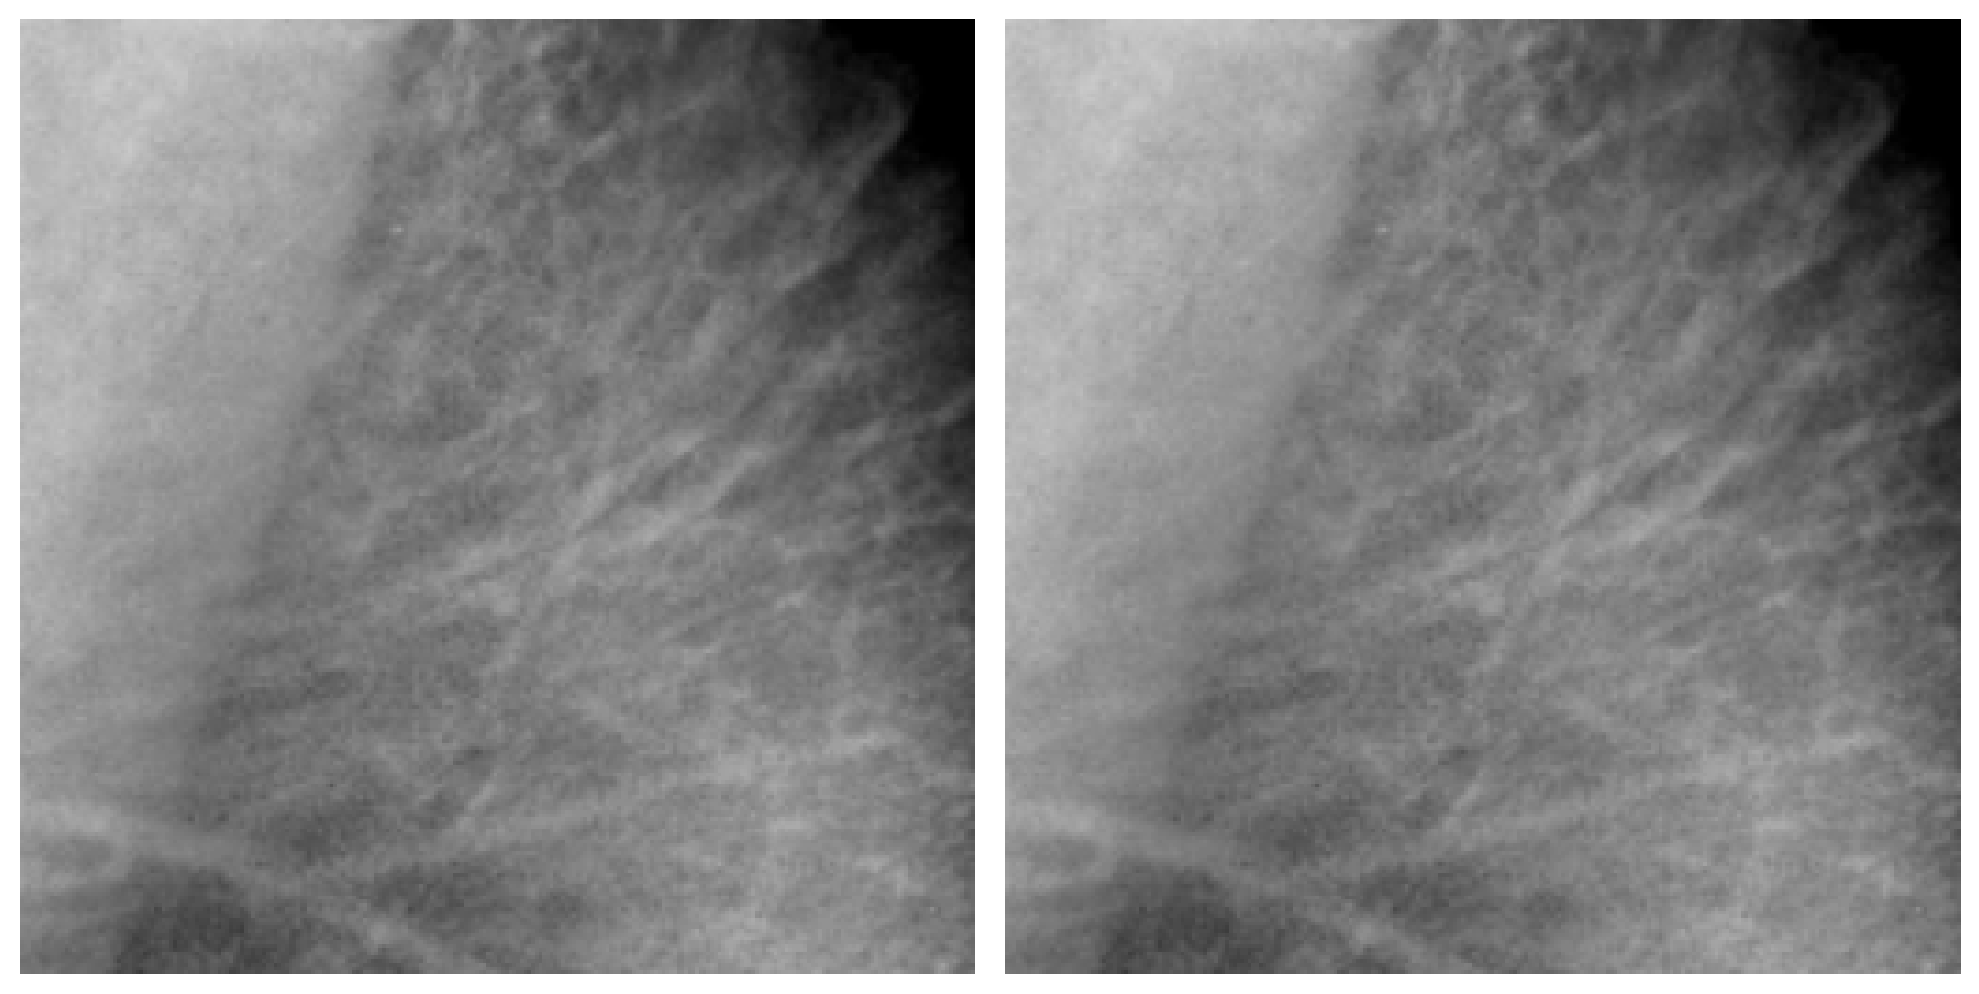

In [10]:
for i, batch in enumerate(valid_dataloader):
  x, y = batch

  x = torch.stack([x,x,x], 1)
  display_blend([
    [re_normalize(x[0].permute(1,2,0).numpy()), mammograms_label_to_rgb(y[0])],
    [re_normalize(x[0].permute(1,2,0).numpy()), mammograms_label_to_rgb(y[0])]
  ])

  break

torch.Size([256, 256])
torch.Size([256, 256])


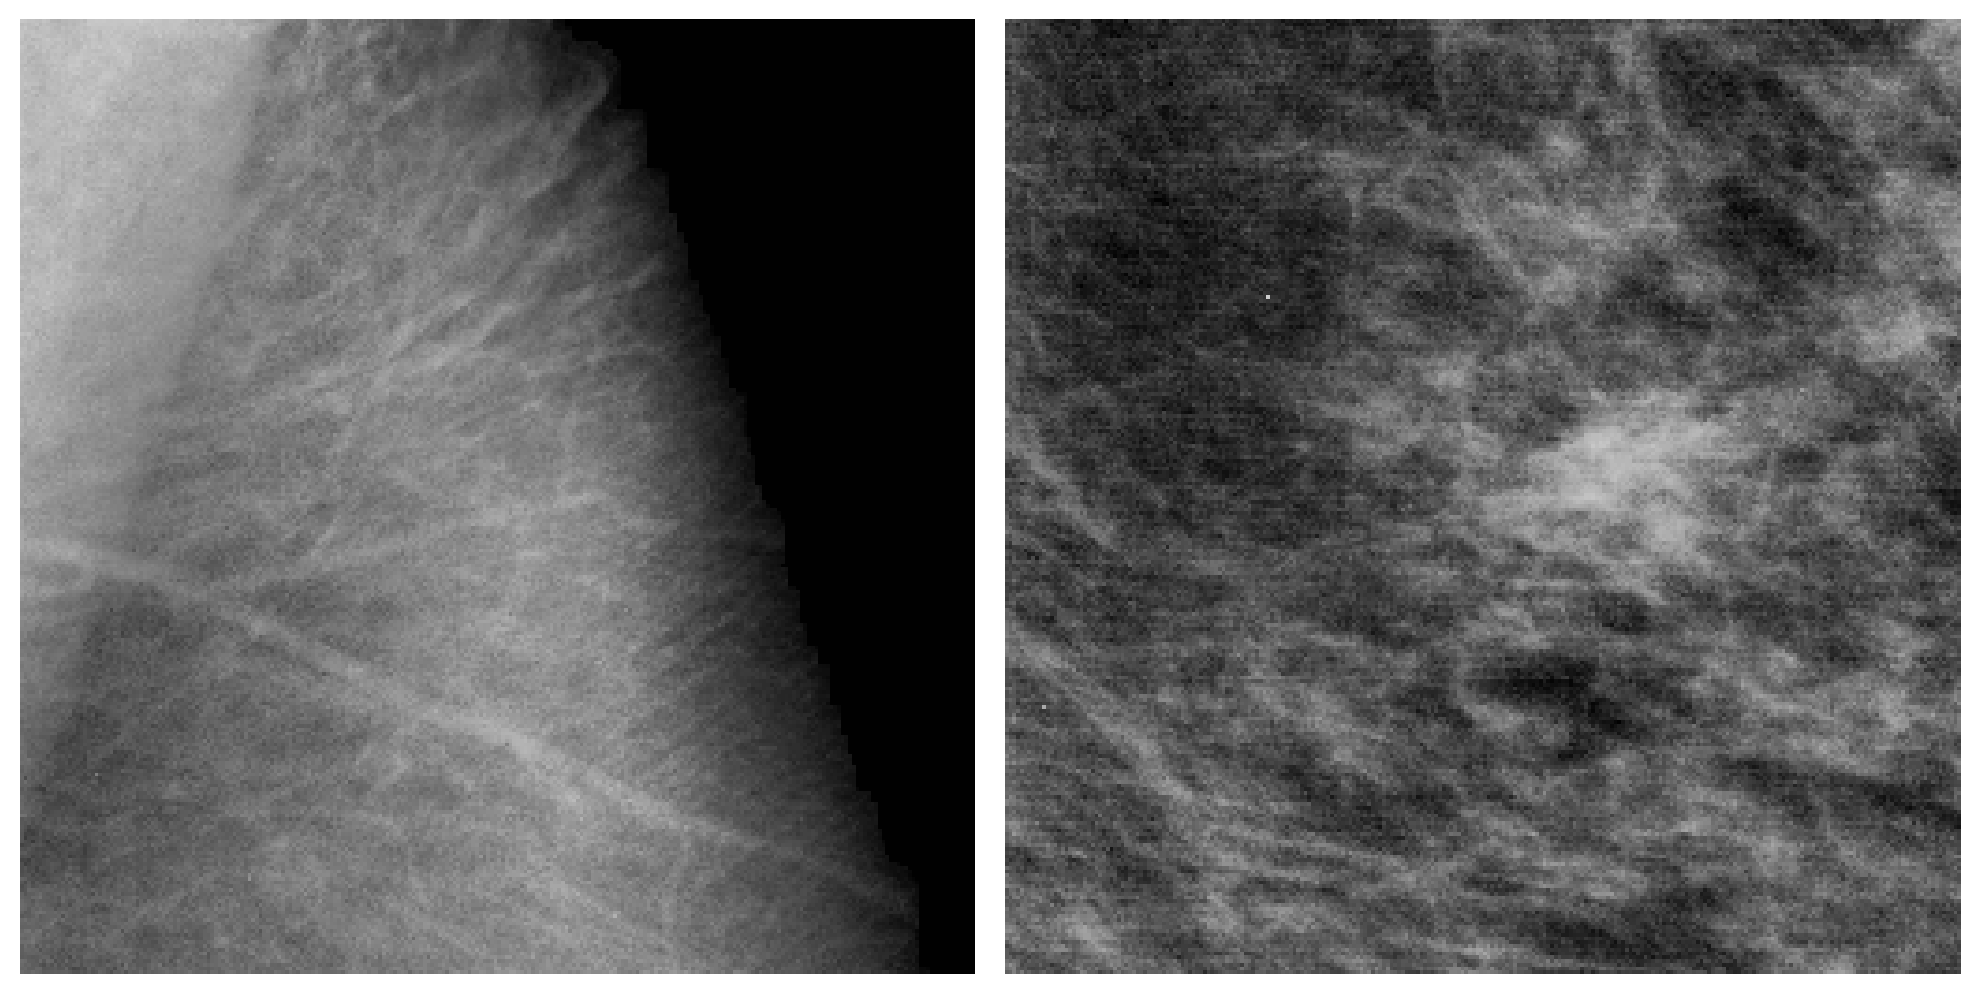

In [11]:
idx1 = 0
idx2 = 1
display_blend([
    [re_normalize(xv[idx1].permute(1,2,0).numpy()), mammograms_label_to_rgb(yv[idx1])],
    [re_normalize(xv[idx2].permute(1,2,0).numpy()), mammograms_label_to_rgb(yv[idx2])]
])

In [12]:
SEG_CFG = cfg.MODEL.B0
cfg.NUM_CLASSES = 1
print(SEG_CFG)

CHANNEL_DIMS: (32, 64, 160, 256)
DECODER_DIM: 256
DEPTHS: (2, 2, 2, 2)
DROP_PATH_RATE: 0.1
DROP_RATE: 0.0
MLP_RATIOS: (4, 4, 4, 4)
NUM_HEADS: (1, 2, 5, 8)
PRETRAINED: weights/mit_b0.pth
QKV_BIAS: True
SR_RATIOS: (8, 4, 2, 1)


In [13]:
from models.segformer_shift import Segformer

In [14]:
import gc
gc.collect()

6354

In [15]:
model = Segformer(
    pretrained = "/content/drive/MyDrive/pretrained_models/mit_b0.pth", # CHECK THIS TO LOAD PRETRAINED MODEL
    img_size = 256,
                  patch_size = cfg.MODEL.PATCH_SIZE, embed_dims = SEG_CFG.CHANNEL_DIMS, num_heads = SEG_CFG.NUM_HEADS,
                  mlp_ratios = SEG_CFG.MLP_RATIOS, qkv_bias = SEG_CFG.QKV_BIAS, depths = SEG_CFG.DEPTHS,
                  sr_ratios = SEG_CFG.SR_RATIOS, drop_rate = SEG_CFG.DROP_RATE, drop_path_rate = SEG_CFG.DROP_PATH_RATE,
                  decoder_dim = SEG_CFG.DECODER_DIM, norm_layer = partial(nn.LayerNorm, eps = 1e-6),
                  overlap_patch_embed = True,
                  masked_attention = False,
                  use_drloc = True,
                  drloc_mode = 'l1',
                  sample_size = 384
                  ).to(device)

2023-01-13 15:33:54,584 - mmseg - INFO - load checkpoint from local path: /content/drive/MyDrive/pretrained_models/mit_b0.pth
2023-01-13 15:33:54,620 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for patch_embed1.proj.weight: copying a param with shape torch.Size([32, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 15, 7, 7]).
size mismatch for patch_embed2.proj.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 160, 3, 3]).
size mismatch for patch_embed3.proj.weight: copying a param with shape torch.Size([160, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([160, 320, 3, 3]).
size mismatch for patch_embed4.proj.weight: copying a param with shape torch.Size([256, 160, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 800, 3, 3]).
unexpected key in source state_dict: head.weight, head.bias, block1.0.attn.sr

In [16]:
# PyTorch
from munch import Munch

import torch
import torch.nn as nn
import torch.nn.functional as F

class CalSSLoss():
    def __init__(self, drloc_mode = 'l1'):

        self.drloc_mode = drloc_mode
        if drloc_mode == "l1":  # l1 regression constraint
            self.reld_criterion = self.relative_constraint_l1
        elif drloc_mode == "ce":  # cross entropy constraint
            self.reld_criterion = self.relative_constraint_ce
        elif drloc_mode == "cbr":  # cycle-back regression constaint: https://arxiv.org/pdf/1904.07846.pdf
            self.reld_criterion = self.relative_constraint_cbr
        else:
            raise NotImplementedError("We only support l1, ce and cbr now.")
    def relative_constraint_l1(self, deltaxy, predxy):
        return F.l1_loss(deltaxy, predxy)

    def relative_constraint_ce(self, deltaxy, predxy):
        # predx, predy = torch.chunk(predxy, chunks=2, dim=1)
        predx, predy = predxy[:, :, 0], predxy[:, :, 1]
        targetx, targety = deltaxy[:, 0].long(), deltaxy[:, 1].long()
        return F.cross_entropy(predx, targetx) + F.cross_entropy(predy, targety)

    def variance_aware_regression(self, pred, beta, target, labels, lambda_var = 0.001):
        # Variance aware regression.
        pred_titled = pred.unsqueeze(0).t().repeat(1, labels.size(1))
        EPSILON = 1e-8
        pred_var = torch.sum((labels - pred_titled) ** 2 * beta, dim = 1) + EPSILON
        pred_log_var = torch.log(pred_var)
        squared_error = (pred - target) ** 2
        return torch.mean(torch.exp(-pred_log_var) * squared_error + lambda_var * pred_log_var)

    # based on the codes: https://github.com/google-research/google-research/blob/master/tcc/tcc/losses.py
    def relative_constraint_cbr(self, deltaxy, predxy, loss_type = "regression_mse_var"):
        predx, predy = predxy[:, :, 0], predxy[:, :, 1]
        num_classes = predx.size(1)
        targetx, targety = deltaxy[:, 0].long(), deltaxy[:, 1].long()  # [N, ], [N, ]
        betax, betay = F.softmax(predx, dim = 1), F.softmax(predy, dim = 1)  # [N, C], [N, C]
        labels = torch.arange(num_classes).unsqueeze(0).to(predxy.device)  # [1, C]
        true_idx = targetx  # torch.sum(targetx*labels, dim=1)      # [N, ]
        true_idy = targety  # torch.sum(targety*labels, dim=1)      # [N, ]

        pred_idx = torch.sum(betax * labels, dim = 1)  # [N, ]
        pred_idy = torch.sum(betay * labels, dim = 1)  # [N, ]

        if loss_type in ["regression_mse", "regression_mse_var"]:
            if "var" in loss_type:
                # Variance aware regression.
                lossx = self.variance_aware_regression(pred_idx, betax, true_idx, labels)
                lossy = self.variance_aware_regression(pred_idy, betay, true_idy, labels)
            else:
                lossx = torch.mean((pred_idx - true_idx) ** 2)
                lossy = torch.mean((pred_idy - true_idy) ** 2)
            losss = lossx + lossy
            return losss
        else:
            raise NotImplementedError("We only support regression_mse and regression_mse_var now.")

    def forward(self, outs, lambda_drloc = 0.0):
        losss, all_losses = 0.0, Munch()
        loss_drloc = 0.0


        for deltaxy, drloc, plane_size in zip(outs.deltaxy1, outs.drloc1, outs.plz1):
            loss_drloc += self.reld_criterion(deltaxy, drloc) * (lambda_drloc**8)

        for deltaxy, drloc, plane_size in zip(outs.deltaxy2, outs.drloc2, outs.plz2):
            loss_drloc += self.reld_criterion(deltaxy, drloc) * (lambda_drloc**4)

        for deltaxy, drloc, plane_size in zip(outs.deltaxy3, outs.drloc3, outs.plz3):
            loss_drloc += self.reld_criterion(deltaxy, drloc) * (lambda_drloc**2)

        for deltaxy, drloc, plane_size in zip(outs.deltaxy4, outs.drloc4, outs.plz4):
            loss_drloc += self.reld_criterion(deltaxy, drloc) * (lambda_drloc**1)

        all_losses.drloc = loss_drloc.item()
        losss += loss_drloc

        return losss, all_losses


In [17]:
#w = torch.FloatTensor([1,1])

# binary classification loss function
criterion = FocalTverskyLoss(
).to(device)

loss2 = CalSSLoss(drloc_mode = 'l1')

# configuration for the model's optimizer
optimizer_cfg = dict(
    type='Adam', #AdamW
    lr=1e-4)  #  0.00006)

# build model optimizer
optimizer = build_optimizer(model, optimizer_cfg)


# A LearningRateSchedule that uses a polynomial decay schedule
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-5, cycle_momentum=False)

In [18]:
x2 =  F.interpolate(x, size = 64, mode = 'bilinear', align_corners = False)

In [19]:
print(x2.shape)

torch.Size([4, 3, 64, 64])


In [20]:
x2 = torch.ones((1, 3, 256,256)).to(device)

In [21]:
details = get_model_summary(model, x2.cuda(), verbose=True)
print(details)

Model Summary
Name                Input Size          Output Size         Parameters          Multiply Adds (Flops)
----------------------------------------------------------------------------------------------------
ShiftedConcatenator_1[1, 3, 256, 256]    [1, 15, 256, 256]   0                   Not Available       
----------------------------------------------------------------------------------------------------
Conv2d_1            [1, 15, 256, 256]   [1, 32, 64, 64]     23552               96337920            
----------------------------------------------------------------------------------------------------
LayerNorm_1         [1, 4096, 32]       [1, 4096, 32]       0                   Not Available       
----------------------------------------------------------------------------------------------------
OverlapPatchEmbedSPT_1[1, 3, 256, 256]    [1, 4096, 32]       0                   Not Available       
-------------------------------------------------------------------------

In [22]:
#PyTorch
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        t = torch.Tensor([0.5]).to(device)  # threshold
        inputs = (inputs > t).float() 

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [23]:
!{sys.executable} -m pip install torchmetrics
from torchmetrics import JaccardIndex
def train(
    cfg, 
    dataloader, 
    model, 
    loss_fn,
    optimizer, 
    lr_scheduler, 
    scaler, 
    writer_dict,
    epoch, 
    loss_fn2 = None
):
    model.train()
    
    ave_loss = AverageMeter() # object to compute and store the average and current value
    ave_iou = AverageMeter()
    steps_tot = epoch*len(dataloader) # overall amount of steps, as the number of total passes of samples in the network (e.g epoch = 2, len(dataloander) = batch_size = 5, steps_tot = 10)
    writer = writer_dict['writer']
    global_steps = writer_dict['train_global_steps'] # global steps are the so far total number of epochs completed
    Jaccard = IoU().to(device)
    
    # loops over each batch (e.g: size 2 batch)
    for step, batch in enumerate(dataloader):
        X, y = batch # input, target
        X = torch.stack([X,X,X], 1)
        #X = F.interpolate(X, size = 64, mode = 'bilinear', align_corners = False)
        X, y = X.cuda(), y.long().cuda()
        
        # Compute prediction and loss
        with torch.cuda.amp.autocast():
            out = model(X.contiguous()) # Returns a contiguous in memory tensor containing the same data as self tensor
            pred = out.x.clone()
            pred = pred.double()
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False) # since the model's output is (64x64), it has to be rescaled to same size as input

            losses = loss_fn(torch.squeeze(pred).double(), y) # computes loss for each sample
            #print(pred.dtype)
            iou = Jaccard(torch.squeeze(pred).double(), y)
            """if torch.isnan(iou).any():
              print(torch.isnan(iou).any())"""
            iou = iou.nanmean()
 
            if loss_fn2:
              loss_ssup, ssup_items = loss_fn2.forward(out, 0.1)
              
            loss = losses.mean() # single loss that is the averge of all the losses of the batch

            if loss_fn2:
              loss = loss+loss_ssup
              #loss = loss



            # update average loss <- WHY JUST THE FINAL LOSS IS CONSIDERED??????
            ave_loss.update(loss.item())
            ave_iou.update(iou.item())
            print("\r", ave_loss.average(), end="")
            # Normalize loss to account for batch accumulation
            loss = loss / cfg.TRAIN.ACCUM_STEPS 
            
        # Backward pass to compute the gradients
        scaler.scale(loss).backward()
        
        # Weight update
        if ((step + 1) % cfg.TRAIN.ACCUM_STEPS == 0) or (step + 1 == len(dataloader)):

            # Unscales the gradients of optimizer's assigned params in-place
            scaler.unscale_(optimizer)

            # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() # set the gradients to 0 after updating the weights, in this way the next accumulation of gradients starts from 0 gradient

            #print("\r", iou.item(), end="")
            # update learning schedule
            lr_scheduler.step()
            lr = lr_scheduler.get_lr()
        
        
    writer.add_scalar('train_loss', ave_loss.average(), global_steps) # current AVERAGE TRAINING LOSS
    writer_dict['train_global_steps'] = global_steps + 1 # UPDATES EPOCH STEP

    return ave_loss.average(), ave_iou.average()

    
    
def validate(
    cfg, 
    dataloader, 
    model, 
    loss_fn,
    writer_dict,
    loss_fn2 = None
):
    model.eval() 
    
    ave_loss = AverageMeter()  # object to compute and store the average and current value
    ave_iou = AverageMeter()
    Jaccard = IoU().to(device)
    iter_steps = len(dataloader.dataset) // cfg.TRAIN.BATCH_SIZE # computes the number of steps required for a single pass of the whole dataset, given the batch size
    confusion_matrix = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES, 1))

    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            X, y = batch
            X = torch.stack([X,X,X], 1)
            #X = F.interpolate(X, size = 64, mode = 'bilinear', align_corners = False)
            X, y = X.cuda(), y.long().cuda()
            
            out = model(X.contiguous())
            pred = out.x
            pred = pred.double()
            pred = F.interpolate(pred, size = 256, mode = 'bilinear', align_corners = False)
            losses = loss_fn(torch.squeeze(pred).double(), y.double())
            iou = Jaccard(torch.squeeze(pred).double(),y.double())
            iou = iou.nanmean()
            if loss_fn2:
              loss_ssup, ssup_items = loss_fn2.forward(out, 0.1)
              loss_ssup = loss_ssup.mean()
            loss = losses.mean()   

            if loss_fn2:
              loss = loss + loss_ssup

            ave_loss.update(loss.item())      
            ave_iou.update(iou.item())

    writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']
    writer.add_scalar('valid_loss', ave_loss.average(), global_steps)
    writer.add_scalar('valid_mIoU', ave_iou.average(), global_steps)
    for key, val in trainid2label.items():
        if key != cfg.DATASET.IGNORE_LABEL and key != -1:
            if val.name == 'traffic light':
                val_name = "traffic_light"
            elif val.name == 'traffic sign':
                val_name = "traffic_sign"
            else:
                val_name = val.name
    writer_dict['valid_global_steps'] = global_steps + 1
        
    return ave_loss.average(), ave_iou.average()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(cfg, cfg_name=cfg.NAME, phase='train')
    
    writer_dict = {'writer': SummaryWriter(tb_log_dir), 'train_global_steps': 0, 'valid_global_steps': 0}

    best_mIoU = 0 # stores the best mean intersection over unit value
    
    start = timeit.default_timer()

    for epoch in range(1000):
        
        e_start = time.time()

        train_loss, t_mean_IoU = train(
            cfg=cfg, 
            dataloader=train_dataloader,
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict,
            loss_fn2 = loss2
        )

        valid_loss, mean_IoU = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict,
            loss_fn2 = loss2

        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        # saves the model after each epoch in a zipped format, overwritting the previous checkpoint
        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth')) # saves the best model so far
            
        e_end = time.time()
        t_epoch = e_end - e_start

        msg = 'Epoch {}/{} --- {:.1f}s, TLoss: {:.3f}, TMeanIoU: {: 4.4f} , Loss: {:.3f}, MeanIoU: {: 4.4f}, Best_mIoU: {: 4.4f}'.format(
            epoch+1, cfg.TRAIN.EPOCHS, t_epoch, train_loss, t_mean_IoU, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth')) # saves the final model
    
    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
 run_train_loop()

 """ 1.7658737223693906/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:1282: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
 1.609340694046417Epoch 1/20 --- 356.2s, TLoss: 1.609, TMeanIoU:  0.0606 , Loss: 1.492, MeanIoU:  0.1046, Best_mIoU:  0.1046
 1.2719257354140199Epoch 2/20 --- 355.6s, TLoss: 1.272, TMeanIoU:  0.1014 , Loss: 1.082, MeanIoU:  0.1083, Best_mIoU:  0.1083
 0.9633924454665544Epoch 3/20 --- 355.8s, TLoss: 0.963, TMeanIoU:  0.1289 , Loss: 0.836, MeanIoU:  0.1443, Best_mIoU:  0.1443
 0.7478171222230009Epoch 4/20 --- 355.4s, TLoss: 0.748, TMeanIoU:  0.1576 , Loss: 0.711, MeanIoU:  0.1478, Best_mIoU:  0.1478
 0.6373411562830397Epoch 5/20 --- 354.7s, TLoss: 0.637, TMeanIoU:  0.1901 , Loss: 0.590, MeanIoU:  0.1986, Best_mIoU:  0.1986
 0.5582773617895336Epoch 6/20 --- 354.3s, TLoss: 0.558, TMeanIoU:  0.2206 , Loss: 0.551, MeanIoU:  0.2306, Best_mIoU:  0.2306
 0.5365597953764683Epoch 7/20 --- 354.6s, TLoss: 0.537, TMeanIoU:  0.2336 , Loss: 0.561, MeanIoU:  0.2403, Best_mIoU:  0.2403
 0.5019950412684466Epoch 8/20 --- 353.3s, TLoss: 0.502, TMeanIoU:  0.2548 , Loss: 0.503, MeanIoU:  0.2524, Best_mIoU:  0.2524
 0.4909612004712434Epoch 9/20 --- 354.5s, TLoss: 0.491, TMeanIoU:  0.2605 , Loss: 0.491, MeanIoU:  0.2563, Best_mIoU:  0.2563
 0.49480763048947746Epoch 10/20 --- 356.3s, TLoss: 0.495, TMeanIoU:  0.2619 , Loss: 0.496, MeanIoU:  0.2600, Best_mIoU:  0.2600
 0.4887837419843183Epoch 11/20 --- 354.6s, TLoss: 0.489, TMeanIoU:  0.2690 , Loss: 0.509, MeanIoU:  0.2725, Best_mIoU:  0.2725
 0.46840437998505985Epoch 12/20 --- 354.3s, TLoss: 0.468, TMeanIoU:  0.2842 , Loss: 0.510, MeanIoU:  0.2504, Best_mIoU:  0.2725
 0.4658607569750039Epoch 13/20 --- 354.7s, TLoss: 0.466, TMeanIoU:  0.2916 , Loss: 0.482, MeanIoU:  0.2828, Best_mIoU:  0.2828
 0.4313493309006063Epoch 14/20 --- 354.7s, TLoss: 0.431, TMeanIoU:  0.3126 , Loss: 0.421, MeanIoU:  0.3262, Best_mIoU:  0.3262
 0.410879720912762Epoch 15/20 --- 352.0s, TLoss: 0.411, TMeanIoU:  0.3262 , Loss: 0.447, MeanIoU:  0.3164, Best_mIoU:  0.3262
 0.3942644638147398Epoch 16/20 --- 352.0s, TLoss: 0.394, TMeanIoU:  0.3420 , Loss: 0.428, MeanIoU:  0.3269, Best_mIoU:  0.3269
 0.38898058890680803Epoch 17/20 --- 351.5s, TLoss: 0.389, TMeanIoU:  0.3472 , Loss: 0.405, MeanIoU:  0.3423, Best_mIoU:  0.3423
 0.3862410463610329Epoch 18/20 --- 351.3s, TLoss: 0.386, TMeanIoU:  0.3515 , Loss: 0.421, MeanIoU:  0.3291, Best_mIoU:  0.3423
 0.39520590172104797Epoch 19/20 --- 351.2s, TLoss: 0.395, TMeanIoU:  0.3433 , Loss: 0.417, MeanIoU:  0.3551, Best_mIoU:  0.3551
 0.38670747224195023Epoch 20/20 --- 351.8s, TLoss: 0.387, TMeanIoU:  0.3446 , Loss: 0.435, MeanIoU:  0.3173, Best_mIoU:  0.3551
 0.3939858051766012Epoch 21/20 --- 351.7s, TLoss: 0.394, TMeanIoU:  0.3447 , Loss: 0.500, MeanIoU:  0.3094, Best_mIoU:  0.3551
 0.3789916094612984Epoch 22/20 --- 351.6s, TLoss: 0.379, TMeanIoU:  0.3575 , Loss: 0.398, MeanIoU:  0.3599, Best_mIoU:  0.3599
 0.3596787236301667Epoch 23/20 --- 350.6s, TLoss: 0.360, TMeanIoU:  0.3700 , Loss: 0.397, MeanIoU:  0.3504, Best_mIoU:  0.3599
 0.35030405021558186Epoch 24/20 --- 351.2s, TLoss: 0.350, TMeanIoU:  0.3817 , Loss: 0.380, MeanIoU:  0.3671, Best_mIoU:  0.3671
 0.3383767463008318Epoch 25/20 --- 350.9s, TLoss: 0.338, TMeanIoU:  0.3914 , Loss: 0.381, MeanIoU:  0.3636, Best_mIoU:  0.3671
 0.3390994411954501Epoch 26/20 --- 353.0s, TLoss: 0.339, TMeanIoU:  0.3952 , Loss: 0.390, MeanIoU:  0.3702, Best_mIoU:  0.3702
 0.34118626794126805Epoch 27/20 --- 352.0s, TLoss: 0.341, TMeanIoU:  0.3882 , Loss: 0.371, MeanIoU:  0.3633, Best_mIoU:  0.3702
 0.3361230073753561Epoch 28/20 --- 350.8s, TLoss: 0.336, TMeanIoU:  0.3885 , Loss: 0.399, MeanIoU:  0.3520, Best_mIoU:  0.3702
 0.3301386040676356Epoch 29/20 --- 351.3s, TLoss: 0.330, TMeanIoU:  0.3924 , Loss: 0.403, MeanIoU:  0.3394, Best_mIoU:  0.3702
 0.3265427987168867Epoch 30/20 --- 351.0s, TLoss: 0.327, TMeanIoU:  0.3959 , Loss: 0.387, MeanIoU:  0.3729, Best_mIoU:  0.3729
 0.32511954051209624Epoch 31/20 --- 353.2s, TLoss: 0.325, TMeanIoU:  0.4039 , Loss: 0.363, MeanIoU:  0.3842, Best_mIoU:  0.3842
 0.29398190063065466Epoch 32/20 --- 350.0s, TLoss: 0.294, TMeanIoU:  0.4292 , Loss: 0.351, MeanIoU:  0.3750, Best_mIoU:  0.3842
 0.3013662053732432Epoch 33/20 --- 349.0s, TLoss: 0.301, TMeanIoU:  0.4304 , Loss: 0.378, MeanIoU:  0.3831, Best_mIoU:  0.3842
 0.295828488118522Epoch 34/20 --- 349.7s, TLoss: 0.296, TMeanIoU:  0.4342 , Loss: 0.363, MeanIoU:  0.3761, Best_mIoU:  0.3842
 0.30068152915518853Epoch 35/20 --- 349.3s, TLoss: 0.301, TMeanIoU:  0.4285 , Loss: 0.388, MeanIoU:  0.3650, Best_mIoU:  0.3842
 0.2899801823062047Epoch 36/20 --- 352.1s, TLoss: 0.290, TMeanIoU:  0.4346 , Loss: 0.390, MeanIoU:  0.3531, Best_mIoU:  0.3842
 0.31283776317265755Epoch 37/20 --- 351.7s, TLoss: 0.313, TMeanIoU:  0.4177 , Loss: 0.341, MeanIoU:  0.3945, Best_mIoU:  0.3945
 0.30286638565971624Epoch 38/20 --- 351.3s, TLoss: 0.303, TMeanIoU:  0.4302 , Loss: 0.363, MeanIoU:  0.3725, Best_mIoU:  0.3945
 0.2958190765682297Epoch 39/20 --- 349.8s, TLoss: 0.296, TMeanIoU:  0.4412 , Loss: 0.340, MeanIoU:  0.3972, Best_mIoU:  0.3972
 0.29650103828245Epoch 40/20 --- 351.1s, TLoss: 0.297, TMeanIoU:  0.4422 , Loss: 0.358, MeanIoU:  0.3890, Best_mIoU:  0.3972
 0.27644768215777693Epoch 41/20 --- 352.6s, TLoss: 0.276, TMeanIoU:  0.4534 , Loss: 0.343, MeanIoU:  0.3847, Best_mIoU:  0.3972
 0.2697778136495629Epoch 42/20 --- 351.3s, TLoss: 0.270, TMeanIoU:  0.4632 , Loss: 0.352, MeanIoU:  0.4013, Best_mIoU:  0.4013
 0.2741411085510428Epoch 43/20 --- 352.1s, TLoss: 0.274, TMeanIoU:  0.4591 , Loss: 0.354, MeanIoU:  0.3864, Best_mIoU:  0.4013
 0.2742696595133932Epoch 44/20 --- 351.3s, TLoss: 0.274, TMeanIoU:  0.4529 , Loss: 0.365, MeanIoU:  0.3684, Best_mIoU:  0.4013
 0.2727273950862455Epoch 45/20 --- 351.2s, TLoss: 0.273, TMeanIoU:  0.4588 , Loss: 0.347, MeanIoU:  0.3920, Best_mIoU:  0.4013
 0.2861541668503009Epoch 46/20 --- 351.7s, TLoss: 0.286, TMeanIoU:  0.4470 , Loss: 0.347, MeanIoU:  0.3762, Best_mIoU:  0.4013
 0.2767122193196073Epoch 47/20 --- 351.6s, TLoss: 0.277, TMeanIoU:  0.4564 , Loss: 0.356, MeanIoU:  0.3713, Best_mIoU:  0.4013
 0.2653774027459708Epoch 48/20 --- 351.1s, TLoss: 0.265, TMeanIoU:  0.4686 , Loss: 0.362, MeanIoU:  0.3804, Best_mIoU:  0.4013
 0.25182939875541777Epoch 49/20 --- 352.6s, TLoss: 0.252, TMeanIoU:  0.4844 , Loss: 0.345, MeanIoU:  0.3756, Best_mIoU:  0.4013
 0.24227738337588942Epoch 50/20 --- 355.1s, TLoss: 0.242, TMeanIoU:  0.4951 , Loss: 0.317, MeanIoU:  0.4128, Best_mIoU:  0.4128
 0.24407650105623607Epoch 51/20 --- 355.0s, TLoss: 0.244, TMeanIoU:  0.4890 , Loss: 0.343, MeanIoU:  0.3977, Best_mIoU:  0.4128
 0.24739915573141516Epoch 52/20 --- 351.9s, TLoss: 0.247, TMeanIoU:  0.4864 , Loss: 0.324, MeanIoU:  0.3824, Best_mIoU:  0.4128
 0.25201733765416773Epoch 53/20 --- 352.2s, TLoss: 0.252, TMeanIoU:  0.4863 , Loss: 0.353, MeanIoU:  0.3863, Best_mIoU:  0.4128
 0.2551304147111226Epoch 54/20 --- 352.0s, TLoss: 0.255, TMeanIoU:  0.4812 , Loss: 0.337, MeanIoU:  0.4050, Best_mIoU:  0.4128
 0.2509968178240938Epoch 55/20 --- 351.7s, TLoss: 0.251, TMeanIoU:  0.4830 , Loss: 0.344, MeanIoU:  0.4072, Best_mIoU:  0.4128
 0.25430050006399163Epoch 56/20 --- 351.5s, TLoss: 0.254, TMeanIoU:  0.4894 , Loss: 0.338, MeanIoU:  0.3932, Best_mIoU:  0.4128
 0.2293915555214952Epoch 57/20 --- 352.7s, TLoss: 0.229, TMeanIoU:  0.5057 , Loss: 0.337, MeanIoU:  0.4015, Best_mIoU:  0.4128
 0.21265386671239575Epoch 58/20 --- 351.8s, TLoss: 0.213, TMeanIoU:  0.5250 , Loss: 0.342, MeanIoU:  0.3980, Best_mIoU:  0.4128
 0.23020136772048133Epoch 59/20 --- 352.4s, TLoss: 0.230, TMeanIoU:  0.5195 , Loss: 0.326, MeanIoU:  0.3942, Best_mIoU:  0.4128
 0.2256133253274904Epoch 60/20 --- 351.7s, TLoss: 0.226, TMeanIoU:  0.5132 , Loss: 0.320, MeanIoU:  0.4040, Best_mIoU:  0.4128
 0.23534595031107855Epoch 61/20 --- 352.0s, TLoss: 0.235, TMeanIoU:  0.4962 , Loss: 0.316, MeanIoU:  0.4102, Best_mIoU:  0.4128
 0.2366852557029387Epoch 62/20 --- 352.0s, TLoss: 0.237, TMeanIoU:  0.4992 , Loss: 0.326, MeanIoU:  0.4174, Best_mIoU:  0.4174
 0.23404929359789287Epoch 63/20 --- 351.6s, TLoss: 0.234, TMeanIoU:  0.5025 , Loss: 0.339, MeanIoU:  0.3939, Best_mIoU:  0.4174
 0.22937111916503558Epoch 64/20 --- 351.4s, TLoss: 0.229, TMeanIoU:  0.5034 , Loss: 0.334, MeanIoU:  0.4067, Best_mIoU:  0.4174
 0.2240033296766007Epoch 65/20 --- 351.2s, TLoss: 0.224, TMeanIoU:  0.5158 , Loss: 0.317, MeanIoU:  0.4126, Best_mIoU:  0.4174
 0.21551521957956296Epoch 66/20 --- 351.2s, TLoss: 0.216, TMeanIoU:  0.5260 , Loss: 0.338, MeanIoU:  0.3957, Best_mIoU:  0.4174
 0.20188850135080835Epoch 67/20 --- 352.1s, TLoss: 0.202, TMeanIoU:  0.5417 , Loss: 0.348, MeanIoU:  0.3895, Best_mIoU:  0.4174
 0.20778156261211933Epoch 68/20 --- 351.3s, TLoss: 0.208, TMeanIoU:  0.5302 , Loss: 0.359, MeanIoU:  0.3918, Best_mIoU:  0.4174
 0.22199858007874618Epoch 69/20 --- 351.7s, TLoss: 0.222, TMeanIoU:  0.5213 , Loss: 0.337, MeanIoU:  0.4068, Best_mIoU:  0.4174
 0.21608764142969725Epoch 70/20 --- 351.5s, TLoss: 0.216, TMeanIoU:  0.5198 , Loss: 0.374, MeanIoU:  0.3551, Best_mIoU:  0.4174
 0.22641002666240953Epoch 71/20 --- 350.8s, TLoss: 0.226, TMeanIoU:  0.5119 , Loss: 0.356, MeanIoU:  0.3864, Best_mIoU:  0.4174
 0.21560878888719606Epoch 72/20 --- 351.5s, TLoss: 0.216, TMeanIoU:  0.5240 , Loss: 0.321, MeanIoU:  0.4104, Best_mIoU:  0.4174
 0.20355407327258185Epoch 73/20 --- 351.6s, TLoss: 0.204, TMeanIoU:  0.5379 , Loss: 0.332, MeanIoU:  0.4131, Best_mIoU:  0.4174
 0.19411938480684204Epoch 74/20 --- 351.2s, TLoss: 0.194, TMeanIoU:  0.5479 , Loss: 0.318, MeanIoU:  0.4191, Best_mIoU:  0.4191
 0.20050065075298348Epoch 75/20 --- 351.5s, TLoss: 0.201, TMeanIoU:  0.5464 , Loss: 0.324, MeanIoU:  0.4053, Best_mIoU:  0.4191
 0.20758536104955377Epoch 76/20 --- 351.5s, TLoss: 0.208, TMeanIoU:  0.5366 , Loss: 0.335, MeanIoU:  0.4030, Best_mIoU:  0.4191
 0.20177482016539275Epoch 77/20 --- 352.3s, TLoss: 0.202, TMeanIoU:  0.5383 , Loss: 0.341, MeanIoU:  0.3921, Best_mIoU:  0.4191
 0.21940262656087534Epoch 78/20 --- 351.0s, TLoss: 0.219, TMeanIoU:  0.5250 , Loss: 0.358, MeanIoU:  0.3859, Best_mIoU:  0.4191
 0.20211327528760498Epoch 79/20 --- 351.5s, TLoss: 0.202, TMeanIoU:  0.5362 , Loss: 0.327, MeanIoU:  0.4116, Best_mIoU:  0.4191
 0.2084268300544584Epoch 80/20 --- 350.7s, TLoss: 0.208, TMeanIoU:  0.5312 , Loss: 0.321, MeanIoU:  0.4055, Best_mIoU:  0.4191
 0.21024661406688136Epoch 81/20 --- 352.0s, TLoss: 0.210, TMeanIoU:  0.5367 , Loss: 0.318, MeanIoU:  0.4034, Best_mIoU:  0.4191
 0.19333327045089577Epoch 82/20 --- 352.2s, TLoss: 0.193, TMeanIoU:  0.5572 , Loss: 0.322, MeanIoU:  0.4107, Best_mIoU:  0.4191
 0.18545074263968633Epoch 83/20 --- 350.8s, TLoss: 0.185, TMeanIoU:  0.5610 , Loss: 0.340, MeanIoU:  0.3992, Best_mIoU:  0.4191
 0.18973648074442423Epoch 84/20 --- 353.0s, TLoss: 0.190, TMeanIoU:  0.5616 , Loss: 0.326, MeanIoU:  0.4174, Best_mIoU:  0.4191
 0.20235825631802398Epoch 85/20 --- 351.7s, TLoss: 0.202, TMeanIoU:  0.5443 , Loss: 0.324, MeanIoU:  0.4084, Best_mIoU:  0.4191
 0.19603612260041609Epoch 86/20 --- 354.9s, TLoss: 0.196, TMeanIoU:  0.5502 , Loss: 0.321, MeanIoU:  0.4098, Best_mIoU:  0.4191
 0.19596703129250623Epoch 87/20 --- 355.3s, TLoss: 0.196, TMeanIoU:  0.5459 , Loss: 0.345, MeanIoU:  0.3744, Best_mIoU:  0.4191
 0.1873754104525448Epoch 88/20 --- 354.2s, TLoss: 0.187, TMeanIoU:  0.5505 , Loss: 0.318, MeanIoU:  0.4208, Best_mIoU:  0.4208
 0.1985054601169445Epoch 89/20 --- 355.3s, TLoss: 0.199, TMeanIoU:  0.5474 , Loss: 0.314, MeanIoU:  0.4112, Best_mIoU:  0.4208
 0.19025130969882093Epoch 90/20 --- 351.4s, TLoss: 0.190, TMeanIoU:  0.5644 , Loss: 0.288, MeanIoU:  0.4389, Best_mIoU:  0.4389
 0.18435181885957302Epoch 91/20 --- 351.9s, TLoss: 0.184, TMeanIoU:  0.5694 , Loss: 0.310, MeanIoU:  0.4144, Best_mIoU:  0.4389
 0.17761683935440062Epoch 92/20 --- 352.5s, TLoss: 0.178, TMeanIoU:  0.5721 , Loss: 0.320, MeanIoU:  0.4234, Best_mIoU:  0.4389
 0.18447947101178094Epoch 93/20 --- 352.1s, TLoss: 0.184, TMeanIoU:  0.5663 , Loss: 0.332, MeanIoU:  0.3996, Best_mIoU:  0.4389
 0.18803223759246462Epoch 94/20 --- 351.5s, TLoss: 0.188, TMeanIoU:  0.5542 , Loss: 0.303, MeanIoU:  0.4301, Best_mIoU:  0.4389
 0.20035328033021294Epoch 95/20 --- 352.2s, TLoss: 0.200, TMeanIoU:  0.5415 , Loss: 0.344, MeanIoU:  0.3831, Best_mIoU:  0.4389
 0.18890786274427626Epoch 96/20 --- 351.4s, TLoss: 0.189, TMeanIoU:  0.5542 , Loss: 0.305, MeanIoU:  0.4245, Best_mIoU:  0.4389
 0.19218604888550958Epoch 97/20 --- 351.1s, TLoss: 0.192, TMeanIoU:  0.5570 , Loss: 0.327, MeanIoU:  0.4020, Best_mIoU:  0.4389
 0.18272182172840004Epoch 98/20 --- 352.1s, TLoss: 0.183, TMeanIoU:  0.5681 , Loss: 0.327, MeanIoU:  0.4010, Best_mIoU:  0.4389
 0.17368177715224112Epoch 99/20 --- 350.8s, TLoss: 0.174, TMeanIoU:  0.5846 , Loss: 0.314, MeanIoU:  0.4258, Best_mIoU:  0.4389
 0.17165205470335138Epoch 100/20 --- 351.6s, TLoss: 0.172, TMeanIoU:  0.5875 , Loss: 0.325, MeanIoU:  0.3939, Best_mIoU:  0.4389
 0.17371455249706452Epoch 101/20 --- 350.9s, TLoss: 0.174, TMeanIoU:  0.5807 , Loss: 0.316, MeanIoU:  0.4177, Best_mIoU:  0.4389
 0.18345778690719589Epoch 102/20 --- 351.6s, TLoss: 0.183, TMeanIoU:  0.5654 , Loss: 0.284, MeanIoU:  0.4292, Best_mIoU:  0.4389
 0.17926969802323894Epoch 103/20 --- 350.6s, TLoss: 0.179, TMeanIoU:  0.5683 , Loss: 0.317, MeanIoU:  0.4318, Best_mIoU:  0.4389
 0.1832531705195874Epoch 104/20 --- 352.5s, TLoss: 0.183, TMeanIoU:  0.5576 , Loss: 0.312, MeanIoU:  0.4048, Best_mIoU:  0.4389
 0.18719840128260667Epoch 105/20 --- 351.4s, TLoss: 0.187, TMeanIoU:  0.5589 , Loss: 0.325, MeanIoU:  0.4091, Best_mIoU:  0.4389
 0.18519409747243457Epoch 106/20 --- 352.2s, TLoss: 0.185, TMeanIoU:  0.5686 , Loss: 0.334, MeanIoU:  0.3960, Best_mIoU:  0.4389
 0.1606750185892714Epoch 107/20 --- 352.7s, TLoss: 0.161, TMeanIoU:  0.5917 , Loss: 0.309, MeanIoU:  0.4155, Best_mIoU:  0.4389
 0.1628817516800593Epoch 108/20 --- 353.3s, TLoss: 0.163, TMeanIoU:  0.5982 , Loss: 0.289, MeanIoU:  0.4362, Best_mIoU:  0.4389
 0.15974161078985372Epoch 109/20 --- 351.9s, TLoss: 0.160, TMeanIoU:  0.5917 , Loss: 0.287, MeanIoU:  0.4407, Best_mIoU:  0.4407
 0.17295979986605597Epoch 110/20 --- 350.7s, TLoss: 0.173, TMeanIoU:  0.5787 , Loss: 0.323, MeanIoU:  0.4121, Best_mIoU:  0.4407
 0.18110405606936153Epoch 111/20 --- 350.9s, TLoss: 0.181, TMeanIoU:  0.5750 , Loss: 0.307, MeanIoU:  0.4345, Best_mIoU:  0.4407
 0.1827666524993758Epoch 112/20 --- 351.0s, TLoss: 0.183, TMeanIoU:  0.5611 , Loss: 0.341, MeanIoU:  0.4135, Best_mIoU:  0.4407
 0.1800414286940513Epoch 113/20 --- 351.2s, TLoss: 0.180, TMeanIoU:  0.5759 , Loss: 0.345, MeanIoU:  0.3889, Best_mIoU:  0.4407
 0.17957299792679224Epoch 114/20 --- 350.6s, TLoss: 0.180, TMeanIoU:  0.5731 , Loss: 0.288, MeanIoU:  0.4343, Best_mIoU:  0.4407
 0.16990257444289597Epoch 115/20 --- 352.7s, TLoss: 0.170, TMeanIoU:  0.5882 , Loss: 0.333, MeanIoU:  0.4051, Best_mIoU:  0.4407
 0.15163518912720525Epoch 116/20 --- 355.5s, TLoss: 0.152, TMeanIoU:  0.6047 , Loss: 0.313, MeanIoU:  0.4168, Best_mIoU:  0.4407
 0.16869014917308295Epoch 117/20 --- 353.2s, TLoss: 0.169, TMeanIoU:  0.5973 , Loss: 0.333, MeanIoU:  0.4020, Best_mIoU:  0.4407
 0.16688694595086281Epoch 118/20 --- 352.6s, TLoss: 0.167, TMeanIoU:  0.5905 , Loss: 0.336, MeanIoU:  0.4035, Best_mIoU:  0.4407
 0.1643811904219502Epoch 119/20 --- 352.7s, TLoss: 0.164, TMeanIoU:  0.5843 , Loss: 0.338, MeanIoU:  0.4101, Best_mIoU:  0.4407
 0.1662272997019968Epoch 120/20 --- 352.4s, TLoss: 0.166, TMeanIoU:  0.5811 , Loss: 0.296, MeanIoU:  0.4398, Best_mIoU:  0.4407
 0.17427154488154514Epoch 121/20 --- 351.7s, TLoss: 0.174, TMeanIoU:  0.5750 , Loss: 0.328, MeanIoU:  0.4056, Best_mIoU:  0.4407
 0.15750960166384267Epoch 122/20 --- 352.1s, TLoss: 0.158, TMeanIoU:  0.5942 , Loss: 0.313, MeanIoU:  0.4227, Best_mIoU:  0.4407
 0.16090690138382496Epoch 123/20 --- 351.9s, TLoss: 0.161, TMeanIoU:  0.5929 , Loss: 0.313, MeanIoU:  0.4155, Best_mIoU:  0.4407
 0.1432992849939885Epoch 124/20 --- 352.2s, TLoss: 0.143, TMeanIoU:  0.6140 , Loss: 0.303, MeanIoU:  0.4167, Best_mIoU:  0.4407
 0.14993068983142008Epoch 125/20 --- 351.1s, TLoss: 0.150, TMeanIoU:  0.6109 , Loss: 0.318, MeanIoU:  0.4165, Best_mIoU:  0.4407
 0.15568580548878533Epoch 126/20 --- 352.2s, TLoss: 0.156, TMeanIoU:  0.6005 , Loss: 0.324, MeanIoU:  0.4077, Best_mIoU:  0.4407
 0.15865807081563355Epoch 127/20 --- 352.4s, TLoss: 0.159, TMeanIoU:  0.5957 , Loss: 0.321, MeanIoU:  0.4117, Best_mIoU:  0.4407
 0.1608254796081663Epoch 128/20 --- 352.9s, TLoss: 0.161, TMeanIoU:  0.5957 , Loss: 0.314, MeanIoU:  0.4166, Best_mIoU:  0.4407
 0.1620820166462765Epoch 129/20 --- 352.3s, TLoss: 0.162, TMeanIoU:  0.5914 , Loss: 0.329, MeanIoU:  0.4012, Best_mIoU:  0.4407
 0.15947544086815388Epoch 130/20 --- 353.2s, TLoss: 0.159, TMeanIoU:  0.5980 , Loss: 0.331, MeanIoU:  0.3903, Best_mIoU:  0.4407
 0.15699873850722545Epoch 131/20 --- 353.1s, TLoss: 0.157, TMeanIoU:  0.5990 , Loss: 0.317, MeanIoU:  0.4094, Best_mIoU:  0.4407
 0.15148658299628515Epoch 132/20 --- 352.3s, TLoss: 0.151, TMeanIoU:  0.6124 , Loss: 0.335, MeanIoU:  0.4002, Best_mIoU:  0.4407
 0.1532186485713092Epoch 133/20 --- 352.7s, TLoss: 0.153, TMeanIoU:  0.6125 , Loss: 0.332, MeanIoU:  0.4045, Best_mIoU:  0.4407
 0.17227134477304964Epoch 134/20 --- 353.2s, TLoss: 0.172, TMeanIoU:  0.5991 , Loss: 0.311, MeanIoU:  0.4133, Best_mIoU:  0.4407
 0.15820393818680736Epoch 135/20 --- 352.8s, TLoss: 0.158, TMeanIoU:  0.6044 , Loss: 0.333, MeanIoU:  0.3758, Best_mIoU:  0.4407
 0.15665350116303844Epoch 136/20 --- 352.5s, TLoss: 0.157, TMeanIoU:  0.5996 , Loss: 0.325, MeanIoU:  0.4276, Best_mIoU:  0.4407
 0.16100256498318027Epoch 137/20 --- 351.6s, TLoss: 0.161, TMeanIoU:  0.5916 , Loss: 0.316, MeanIoU:  0.4263, Best_mIoU:  0.4407
 0.15576273007249872Epoch 138/20 --- 352.7s, TLoss: 0.156, TMeanIoU:  0.5977 , Loss: 0.324, MeanIoU:  0.4042, Best_mIoU:  0.4407
 0.14437680388668653Epoch 139/20 --- 351.8s, TLoss: 0.144, TMeanIoU:  0.6167 , Loss: 0.303, MeanIoU:  0.4040, Best_mIoU:  0.4407
 0.1541120803994716Epoch 140/20 --- 351.4s, TLoss: 0.154, TMeanIoU:  0.6088 , Loss: 0.332, MeanIoU:  0.3935, Best_mIoU:  0.4407
 0.1481289522566457Epoch 141/20 --- 351.1s, TLoss: 0.148, TMeanIoU:  0.6157 , Loss: 0.310, MeanIoU:  0.4118, Best_mIoU:  0.4407
 0.14079575833255595Epoch 142/20 --- 351.1s, TLoss: 0.141, TMeanIoU:  0.6223 , Loss: 0.333, MeanIoU:  0.3907, Best_mIoU:  0.4407
 0.14328466011576632Epoch 143/20 --- 350.9s, TLoss: 0.143, TMeanIoU:  0.6173 , Loss: 0.314, MeanIoU:  0.4234, Best_mIoU:  0.4407
 0.15901755135027643Epoch 144/20 --- 350.6s, TLoss: 0.159, TMeanIoU:  0.5985 , Loss: 0.293, MeanIoU:  0.4317, Best_mIoU:  0.4407
 0.158654531381925Epoch 145/20 --- 350.8s, TLoss: 0.159, TMeanIoU:  0.5979 , Loss: 0.311, MeanIoU:  0.4286, Best_mIoU:  0.4407
 0.15041207740263338Epoch 146/20 --- 350.7s, TLoss: 0.150, TMeanIoU:  0.6041 , Loss: 0.341, MeanIoU:  0.4152, Best_mIoU:  0.4407
 0.15785803319682173Epoch 147/20 --- 351.3s, TLoss: 0.158, TMeanIoU:  0.6030 , Loss: 0.324, MeanIoU:  0.4007, Best_mIoU:  0.4407
 0.14224886344877435Epoch 148/20 --- 353.0s, TLoss: 0.142, TMeanIoU:  0.6162 , Loss: 0.304, MeanIoU:  0.4222, Best_mIoU:  0.4407
 0.15040090454694865"""

=> creating /content/segmentation_pytorch/outputs
=> creating /content/segmentation_pytorch/logs
=> creating /content/segmentation_pytorch/outputs/cityscapes/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400
=> creating /content/segmentation_pytorch/logs/cityscapes/segformer/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400_2023-01-13-15-33
 1.7658737223693906

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:1282: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


 1.609340694046417

Epoch 1/20 --- 356.2s, TLoss: 1.609, TMeanIoU:  0.0606 , Loss: 1.492, MeanIoU:  0.1046, Best_mIoU:  0.1046


 1.2719257354140199

Epoch 2/20 --- 355.6s, TLoss: 1.272, TMeanIoU:  0.1014 , Loss: 1.082, MeanIoU:  0.1083, Best_mIoU:  0.1083


 0.9633924454665544

Epoch 3/20 --- 355.8s, TLoss: 0.963, TMeanIoU:  0.1289 , Loss: 0.836, MeanIoU:  0.1443, Best_mIoU:  0.1443


 0.7478171222230009

Epoch 4/20 --- 355.4s, TLoss: 0.748, TMeanIoU:  0.1576 , Loss: 0.711, MeanIoU:  0.1478, Best_mIoU:  0.1478


 0.6373411562830397

Epoch 5/20 --- 354.7s, TLoss: 0.637, TMeanIoU:  0.1901 , Loss: 0.590, MeanIoU:  0.1986, Best_mIoU:  0.1986


 0.5582773617895336

Epoch 6/20 --- 354.3s, TLoss: 0.558, TMeanIoU:  0.2206 , Loss: 0.551, MeanIoU:  0.2306, Best_mIoU:  0.2306


 0.5365597953764683

Epoch 7/20 --- 354.6s, TLoss: 0.537, TMeanIoU:  0.2336 , Loss: 0.561, MeanIoU:  0.2403, Best_mIoU:  0.2403


 0.5019950412684466

Epoch 8/20 --- 353.3s, TLoss: 0.502, TMeanIoU:  0.2548 , Loss: 0.503, MeanIoU:  0.2524, Best_mIoU:  0.2524


 0.4909612004712434

Epoch 9/20 --- 354.5s, TLoss: 0.491, TMeanIoU:  0.2605 , Loss: 0.491, MeanIoU:  0.2563, Best_mIoU:  0.2563


 0.49480763048947746

Epoch 10/20 --- 356.3s, TLoss: 0.495, TMeanIoU:  0.2619 , Loss: 0.496, MeanIoU:  0.2600, Best_mIoU:  0.2600


 0.4887837419843183

Epoch 11/20 --- 354.6s, TLoss: 0.489, TMeanIoU:  0.2690 , Loss: 0.509, MeanIoU:  0.2725, Best_mIoU:  0.2725


 0.46840437998505985

Epoch 12/20 --- 354.3s, TLoss: 0.468, TMeanIoU:  0.2842 , Loss: 0.510, MeanIoU:  0.2504, Best_mIoU:  0.2725


 0.4658607569750039

Epoch 13/20 --- 354.7s, TLoss: 0.466, TMeanIoU:  0.2916 , Loss: 0.482, MeanIoU:  0.2828, Best_mIoU:  0.2828


 0.4313493309006063

Epoch 14/20 --- 354.7s, TLoss: 0.431, TMeanIoU:  0.3126 , Loss: 0.421, MeanIoU:  0.3262, Best_mIoU:  0.3262


 0.410879720912762

Epoch 15/20 --- 352.0s, TLoss: 0.411, TMeanIoU:  0.3262 , Loss: 0.447, MeanIoU:  0.3164, Best_mIoU:  0.3262


 0.3942644638147398

Epoch 16/20 --- 352.0s, TLoss: 0.394, TMeanIoU:  0.3420 , Loss: 0.428, MeanIoU:  0.3269, Best_mIoU:  0.3269


 0.38898058890680803

Epoch 17/20 --- 351.5s, TLoss: 0.389, TMeanIoU:  0.3472 , Loss: 0.405, MeanIoU:  0.3423, Best_mIoU:  0.3423


 0.3862410463610329

Epoch 18/20 --- 351.3s, TLoss: 0.386, TMeanIoU:  0.3515 , Loss: 0.421, MeanIoU:  0.3291, Best_mIoU:  0.3423


 0.39520590172104797

Epoch 19/20 --- 351.2s, TLoss: 0.395, TMeanIoU:  0.3433 , Loss: 0.417, MeanIoU:  0.3551, Best_mIoU:  0.3551


 0.38670747224195023

Epoch 20/20 --- 351.8s, TLoss: 0.387, TMeanIoU:  0.3446 , Loss: 0.435, MeanIoU:  0.3173, Best_mIoU:  0.3551


 0.3939858051766012

Epoch 21/20 --- 351.7s, TLoss: 0.394, TMeanIoU:  0.3447 , Loss: 0.500, MeanIoU:  0.3094, Best_mIoU:  0.3551


 0.3789916094612984

Epoch 22/20 --- 351.6s, TLoss: 0.379, TMeanIoU:  0.3575 , Loss: 0.398, MeanIoU:  0.3599, Best_mIoU:  0.3599


 0.3596787236301667

Epoch 23/20 --- 350.6s, TLoss: 0.360, TMeanIoU:  0.3700 , Loss: 0.397, MeanIoU:  0.3504, Best_mIoU:  0.3599


 0.35030405021558186

Epoch 24/20 --- 351.2s, TLoss: 0.350, TMeanIoU:  0.3817 , Loss: 0.380, MeanIoU:  0.3671, Best_mIoU:  0.3671


 0.3383767463008318

Epoch 25/20 --- 350.9s, TLoss: 0.338, TMeanIoU:  0.3914 , Loss: 0.381, MeanIoU:  0.3636, Best_mIoU:  0.3671


 0.3390994411954501

Epoch 26/20 --- 353.0s, TLoss: 0.339, TMeanIoU:  0.3952 , Loss: 0.390, MeanIoU:  0.3702, Best_mIoU:  0.3702


 0.34118626794126805

Epoch 27/20 --- 352.0s, TLoss: 0.341, TMeanIoU:  0.3882 , Loss: 0.371, MeanIoU:  0.3633, Best_mIoU:  0.3702


 0.3361230073753561

Epoch 28/20 --- 350.8s, TLoss: 0.336, TMeanIoU:  0.3885 , Loss: 0.399, MeanIoU:  0.3520, Best_mIoU:  0.3702


 0.3301386040676356

Epoch 29/20 --- 351.3s, TLoss: 0.330, TMeanIoU:  0.3924 , Loss: 0.403, MeanIoU:  0.3394, Best_mIoU:  0.3702


 0.3265427987168867

Epoch 30/20 --- 351.0s, TLoss: 0.327, TMeanIoU:  0.3959 , Loss: 0.387, MeanIoU:  0.3729, Best_mIoU:  0.3729


 0.32511954051209624

Epoch 31/20 --- 353.2s, TLoss: 0.325, TMeanIoU:  0.4039 , Loss: 0.363, MeanIoU:  0.3842, Best_mIoU:  0.3842


 0.29398190063065466

Epoch 32/20 --- 350.0s, TLoss: 0.294, TMeanIoU:  0.4292 , Loss: 0.351, MeanIoU:  0.3750, Best_mIoU:  0.3842


 0.3013662053732432

Epoch 33/20 --- 349.0s, TLoss: 0.301, TMeanIoU:  0.4304 , Loss: 0.378, MeanIoU:  0.3831, Best_mIoU:  0.3842


 0.295828488118522

Epoch 34/20 --- 349.7s, TLoss: 0.296, TMeanIoU:  0.4342 , Loss: 0.363, MeanIoU:  0.3761, Best_mIoU:  0.3842


 0.30068152915518853

Epoch 35/20 --- 349.3s, TLoss: 0.301, TMeanIoU:  0.4285 , Loss: 0.388, MeanIoU:  0.3650, Best_mIoU:  0.3842


 0.2899801823062047

Epoch 36/20 --- 352.1s, TLoss: 0.290, TMeanIoU:  0.4346 , Loss: 0.390, MeanIoU:  0.3531, Best_mIoU:  0.3842


 0.31283776317265755

Epoch 37/20 --- 351.7s, TLoss: 0.313, TMeanIoU:  0.4177 , Loss: 0.341, MeanIoU:  0.3945, Best_mIoU:  0.3945


 0.30286638565971624

Epoch 38/20 --- 351.3s, TLoss: 0.303, TMeanIoU:  0.4302 , Loss: 0.363, MeanIoU:  0.3725, Best_mIoU:  0.3945


 0.2958190765682297

Epoch 39/20 --- 349.8s, TLoss: 0.296, TMeanIoU:  0.4412 , Loss: 0.340, MeanIoU:  0.3972, Best_mIoU:  0.3972


 0.29650103828245

Epoch 40/20 --- 351.1s, TLoss: 0.297, TMeanIoU:  0.4422 , Loss: 0.358, MeanIoU:  0.3890, Best_mIoU:  0.3972


 0.27644768215777693

Epoch 41/20 --- 352.6s, TLoss: 0.276, TMeanIoU:  0.4534 , Loss: 0.343, MeanIoU:  0.3847, Best_mIoU:  0.3972


 0.2697778136495629

Epoch 42/20 --- 351.3s, TLoss: 0.270, TMeanIoU:  0.4632 , Loss: 0.352, MeanIoU:  0.4013, Best_mIoU:  0.4013


 0.2741411085510428

Epoch 43/20 --- 352.1s, TLoss: 0.274, TMeanIoU:  0.4591 , Loss: 0.354, MeanIoU:  0.3864, Best_mIoU:  0.4013


 0.2742696595133932

Epoch 44/20 --- 351.3s, TLoss: 0.274, TMeanIoU:  0.4529 , Loss: 0.365, MeanIoU:  0.3684, Best_mIoU:  0.4013


 0.2727273950862455

Epoch 45/20 --- 351.2s, TLoss: 0.273, TMeanIoU:  0.4588 , Loss: 0.347, MeanIoU:  0.3920, Best_mIoU:  0.4013


 0.2861541668503009

Epoch 46/20 --- 351.7s, TLoss: 0.286, TMeanIoU:  0.4470 , Loss: 0.347, MeanIoU:  0.3762, Best_mIoU:  0.4013


 0.2767122193196073

Epoch 47/20 --- 351.6s, TLoss: 0.277, TMeanIoU:  0.4564 , Loss: 0.356, MeanIoU:  0.3713, Best_mIoU:  0.4013


 0.2653774027459708

Epoch 48/20 --- 351.1s, TLoss: 0.265, TMeanIoU:  0.4686 , Loss: 0.362, MeanIoU:  0.3804, Best_mIoU:  0.4013


 0.25182939875541777

Epoch 49/20 --- 352.6s, TLoss: 0.252, TMeanIoU:  0.4844 , Loss: 0.345, MeanIoU:  0.3756, Best_mIoU:  0.4013


 0.24227738337588942

Epoch 50/20 --- 355.1s, TLoss: 0.242, TMeanIoU:  0.4951 , Loss: 0.317, MeanIoU:  0.4128, Best_mIoU:  0.4128


 0.24407650105623607

Epoch 51/20 --- 355.0s, TLoss: 0.244, TMeanIoU:  0.4890 , Loss: 0.343, MeanIoU:  0.3977, Best_mIoU:  0.4128


 0.24739915573141516

Epoch 52/20 --- 351.9s, TLoss: 0.247, TMeanIoU:  0.4864 , Loss: 0.324, MeanIoU:  0.3824, Best_mIoU:  0.4128


 0.25201733765416773

Epoch 53/20 --- 352.2s, TLoss: 0.252, TMeanIoU:  0.4863 , Loss: 0.353, MeanIoU:  0.3863, Best_mIoU:  0.4128


 0.2551304147111226

Epoch 54/20 --- 352.0s, TLoss: 0.255, TMeanIoU:  0.4812 , Loss: 0.337, MeanIoU:  0.4050, Best_mIoU:  0.4128


 0.2509968178240938

Epoch 55/20 --- 351.7s, TLoss: 0.251, TMeanIoU:  0.4830 , Loss: 0.344, MeanIoU:  0.4072, Best_mIoU:  0.4128


 0.25430050006399163

Epoch 56/20 --- 351.5s, TLoss: 0.254, TMeanIoU:  0.4894 , Loss: 0.338, MeanIoU:  0.3932, Best_mIoU:  0.4128


 0.2293915555214952

Epoch 57/20 --- 352.7s, TLoss: 0.229, TMeanIoU:  0.5057 , Loss: 0.337, MeanIoU:  0.4015, Best_mIoU:  0.4128


 0.21265386671239575

Epoch 58/20 --- 351.8s, TLoss: 0.213, TMeanIoU:  0.5250 , Loss: 0.342, MeanIoU:  0.3980, Best_mIoU:  0.4128


 0.23020136772048133

Epoch 59/20 --- 352.4s, TLoss: 0.230, TMeanIoU:  0.5195 , Loss: 0.326, MeanIoU:  0.3942, Best_mIoU:  0.4128


 0.2256133253274904

Epoch 60/20 --- 351.7s, TLoss: 0.226, TMeanIoU:  0.5132 , Loss: 0.320, MeanIoU:  0.4040, Best_mIoU:  0.4128


 0.23534595031107855

Epoch 61/20 --- 352.0s, TLoss: 0.235, TMeanIoU:  0.4962 , Loss: 0.316, MeanIoU:  0.4102, Best_mIoU:  0.4128


 0.2366852557029387

Epoch 62/20 --- 352.0s, TLoss: 0.237, TMeanIoU:  0.4992 , Loss: 0.326, MeanIoU:  0.4174, Best_mIoU:  0.4174


 0.23404929359789287

Epoch 63/20 --- 351.6s, TLoss: 0.234, TMeanIoU:  0.5025 , Loss: 0.339, MeanIoU:  0.3939, Best_mIoU:  0.4174


 0.22937111916503558

Epoch 64/20 --- 351.4s, TLoss: 0.229, TMeanIoU:  0.5034 , Loss: 0.334, MeanIoU:  0.4067, Best_mIoU:  0.4174


 0.2240033296766007

Epoch 65/20 --- 351.2s, TLoss: 0.224, TMeanIoU:  0.5158 , Loss: 0.317, MeanIoU:  0.4126, Best_mIoU:  0.4174


 0.21551521957956296

Epoch 66/20 --- 351.2s, TLoss: 0.216, TMeanIoU:  0.5260 , Loss: 0.338, MeanIoU:  0.3957, Best_mIoU:  0.4174


 0.20188850135080835

Epoch 67/20 --- 352.1s, TLoss: 0.202, TMeanIoU:  0.5417 , Loss: 0.348, MeanIoU:  0.3895, Best_mIoU:  0.4174


 0.20778156261211933

Epoch 68/20 --- 351.3s, TLoss: 0.208, TMeanIoU:  0.5302 , Loss: 0.359, MeanIoU:  0.3918, Best_mIoU:  0.4174


 0.22199858007874618

Epoch 69/20 --- 351.7s, TLoss: 0.222, TMeanIoU:  0.5213 , Loss: 0.337, MeanIoU:  0.4068, Best_mIoU:  0.4174


 0.21608764142969725

Epoch 70/20 --- 351.5s, TLoss: 0.216, TMeanIoU:  0.5198 , Loss: 0.374, MeanIoU:  0.3551, Best_mIoU:  0.4174


 0.22641002666240953

Epoch 71/20 --- 350.8s, TLoss: 0.226, TMeanIoU:  0.5119 , Loss: 0.356, MeanIoU:  0.3864, Best_mIoU:  0.4174


 0.21560878888719606

Epoch 72/20 --- 351.5s, TLoss: 0.216, TMeanIoU:  0.5240 , Loss: 0.321, MeanIoU:  0.4104, Best_mIoU:  0.4174


 0.20355407327258185

Epoch 73/20 --- 351.6s, TLoss: 0.204, TMeanIoU:  0.5379 , Loss: 0.332, MeanIoU:  0.4131, Best_mIoU:  0.4174


 0.19411938480684204

Epoch 74/20 --- 351.2s, TLoss: 0.194, TMeanIoU:  0.5479 , Loss: 0.318, MeanIoU:  0.4191, Best_mIoU:  0.4191


 0.20050065075298348

Epoch 75/20 --- 351.5s, TLoss: 0.201, TMeanIoU:  0.5464 , Loss: 0.324, MeanIoU:  0.4053, Best_mIoU:  0.4191


 0.20758536104955377

Epoch 76/20 --- 351.5s, TLoss: 0.208, TMeanIoU:  0.5366 , Loss: 0.335, MeanIoU:  0.4030, Best_mIoU:  0.4191


 0.20177482016539275

Epoch 77/20 --- 352.3s, TLoss: 0.202, TMeanIoU:  0.5383 , Loss: 0.341, MeanIoU:  0.3921, Best_mIoU:  0.4191


 0.21940262656087534

Epoch 78/20 --- 351.0s, TLoss: 0.219, TMeanIoU:  0.5250 , Loss: 0.358, MeanIoU:  0.3859, Best_mIoU:  0.4191


 0.20211327528760498

Epoch 79/20 --- 351.5s, TLoss: 0.202, TMeanIoU:  0.5362 , Loss: 0.327, MeanIoU:  0.4116, Best_mIoU:  0.4191


 0.2084268300544584

Epoch 80/20 --- 350.7s, TLoss: 0.208, TMeanIoU:  0.5312 , Loss: 0.321, MeanIoU:  0.4055, Best_mIoU:  0.4191


 0.21024661406688136

Epoch 81/20 --- 352.0s, TLoss: 0.210, TMeanIoU:  0.5367 , Loss: 0.318, MeanIoU:  0.4034, Best_mIoU:  0.4191


 0.19333327045089577

Epoch 82/20 --- 352.2s, TLoss: 0.193, TMeanIoU:  0.5572 , Loss: 0.322, MeanIoU:  0.4107, Best_mIoU:  0.4191


 0.18545074263968633

Epoch 83/20 --- 350.8s, TLoss: 0.185, TMeanIoU:  0.5610 , Loss: 0.340, MeanIoU:  0.3992, Best_mIoU:  0.4191


 0.18973648074442423

Epoch 84/20 --- 353.0s, TLoss: 0.190, TMeanIoU:  0.5616 , Loss: 0.326, MeanIoU:  0.4174, Best_mIoU:  0.4191


 0.20235825631802398

Epoch 85/20 --- 351.7s, TLoss: 0.202, TMeanIoU:  0.5443 , Loss: 0.324, MeanIoU:  0.4084, Best_mIoU:  0.4191


 0.19603612260041609

Epoch 86/20 --- 354.9s, TLoss: 0.196, TMeanIoU:  0.5502 , Loss: 0.321, MeanIoU:  0.4098, Best_mIoU:  0.4191


 0.19596703129250623

Epoch 87/20 --- 355.3s, TLoss: 0.196, TMeanIoU:  0.5459 , Loss: 0.345, MeanIoU:  0.3744, Best_mIoU:  0.4191


 0.1873754104525448

Epoch 88/20 --- 354.2s, TLoss: 0.187, TMeanIoU:  0.5505 , Loss: 0.318, MeanIoU:  0.4208, Best_mIoU:  0.4208


 0.1985054601169445

Epoch 89/20 --- 355.3s, TLoss: 0.199, TMeanIoU:  0.5474 , Loss: 0.314, MeanIoU:  0.4112, Best_mIoU:  0.4208


 0.19025130969882093

Epoch 90/20 --- 351.4s, TLoss: 0.190, TMeanIoU:  0.5644 , Loss: 0.288, MeanIoU:  0.4389, Best_mIoU:  0.4389


 0.18435181885957302

Epoch 91/20 --- 351.9s, TLoss: 0.184, TMeanIoU:  0.5694 , Loss: 0.310, MeanIoU:  0.4144, Best_mIoU:  0.4389


 0.17761683935440062

Epoch 92/20 --- 352.5s, TLoss: 0.178, TMeanIoU:  0.5721 , Loss: 0.320, MeanIoU:  0.4234, Best_mIoU:  0.4389


 0.18447947101178094

Epoch 93/20 --- 352.1s, TLoss: 0.184, TMeanIoU:  0.5663 , Loss: 0.332, MeanIoU:  0.3996, Best_mIoU:  0.4389


 0.18803223759246462

Epoch 94/20 --- 351.5s, TLoss: 0.188, TMeanIoU:  0.5542 , Loss: 0.303, MeanIoU:  0.4301, Best_mIoU:  0.4389


 0.20035328033021294

Epoch 95/20 --- 352.2s, TLoss: 0.200, TMeanIoU:  0.5415 , Loss: 0.344, MeanIoU:  0.3831, Best_mIoU:  0.4389


 0.18890786274427626

Epoch 96/20 --- 351.4s, TLoss: 0.189, TMeanIoU:  0.5542 , Loss: 0.305, MeanIoU:  0.4245, Best_mIoU:  0.4389


 0.19218604888550958

Epoch 97/20 --- 351.1s, TLoss: 0.192, TMeanIoU:  0.5570 , Loss: 0.327, MeanIoU:  0.4020, Best_mIoU:  0.4389


 0.18272182172840004

Epoch 98/20 --- 352.1s, TLoss: 0.183, TMeanIoU:  0.5681 , Loss: 0.327, MeanIoU:  0.4010, Best_mIoU:  0.4389


 0.17368177715224112

Epoch 99/20 --- 350.8s, TLoss: 0.174, TMeanIoU:  0.5846 , Loss: 0.314, MeanIoU:  0.4258, Best_mIoU:  0.4389


 0.17165205470335138

Epoch 100/20 --- 351.6s, TLoss: 0.172, TMeanIoU:  0.5875 , Loss: 0.325, MeanIoU:  0.3939, Best_mIoU:  0.4389


 0.17371455249706452

Epoch 101/20 --- 350.9s, TLoss: 0.174, TMeanIoU:  0.5807 , Loss: 0.316, MeanIoU:  0.4177, Best_mIoU:  0.4389


 0.18345778690719589

Epoch 102/20 --- 351.6s, TLoss: 0.183, TMeanIoU:  0.5654 , Loss: 0.284, MeanIoU:  0.4292, Best_mIoU:  0.4389


 0.17926969802323894

Epoch 103/20 --- 350.6s, TLoss: 0.179, TMeanIoU:  0.5683 , Loss: 0.317, MeanIoU:  0.4318, Best_mIoU:  0.4389


 0.1832531705195874

Epoch 104/20 --- 352.5s, TLoss: 0.183, TMeanIoU:  0.5576 , Loss: 0.312, MeanIoU:  0.4048, Best_mIoU:  0.4389


 0.18719840128260667

Epoch 105/20 --- 351.4s, TLoss: 0.187, TMeanIoU:  0.5589 , Loss: 0.325, MeanIoU:  0.4091, Best_mIoU:  0.4389


 0.18519409747243457

Epoch 106/20 --- 352.2s, TLoss: 0.185, TMeanIoU:  0.5686 , Loss: 0.334, MeanIoU:  0.3960, Best_mIoU:  0.4389


 0.1606750185892714

Epoch 107/20 --- 352.7s, TLoss: 0.161, TMeanIoU:  0.5917 , Loss: 0.309, MeanIoU:  0.4155, Best_mIoU:  0.4389


 0.1628817516800593

Epoch 108/20 --- 353.3s, TLoss: 0.163, TMeanIoU:  0.5982 , Loss: 0.289, MeanIoU:  0.4362, Best_mIoU:  0.4389


 0.15974161078985372

Epoch 109/20 --- 351.9s, TLoss: 0.160, TMeanIoU:  0.5917 , Loss: 0.287, MeanIoU:  0.4407, Best_mIoU:  0.4407


 0.17295979986605597

Epoch 110/20 --- 350.7s, TLoss: 0.173, TMeanIoU:  0.5787 , Loss: 0.323, MeanIoU:  0.4121, Best_mIoU:  0.4407


 0.18110405606936153

Epoch 111/20 --- 350.9s, TLoss: 0.181, TMeanIoU:  0.5750 , Loss: 0.307, MeanIoU:  0.4345, Best_mIoU:  0.4407


 0.1827666524993758

Epoch 112/20 --- 351.0s, TLoss: 0.183, TMeanIoU:  0.5611 , Loss: 0.341, MeanIoU:  0.4135, Best_mIoU:  0.4407


 0.1800414286940513

Epoch 113/20 --- 351.2s, TLoss: 0.180, TMeanIoU:  0.5759 , Loss: 0.345, MeanIoU:  0.3889, Best_mIoU:  0.4407


 0.17957299792679224

Epoch 114/20 --- 350.6s, TLoss: 0.180, TMeanIoU:  0.5731 , Loss: 0.288, MeanIoU:  0.4343, Best_mIoU:  0.4407


 0.16990257444289597

Epoch 115/20 --- 352.7s, TLoss: 0.170, TMeanIoU:  0.5882 , Loss: 0.333, MeanIoU:  0.4051, Best_mIoU:  0.4407


 0.15163518912720525

Epoch 116/20 --- 355.5s, TLoss: 0.152, TMeanIoU:  0.6047 , Loss: 0.313, MeanIoU:  0.4168, Best_mIoU:  0.4407


 0.16869014917308295

Epoch 117/20 --- 353.2s, TLoss: 0.169, TMeanIoU:  0.5973 , Loss: 0.333, MeanIoU:  0.4020, Best_mIoU:  0.4407


 0.16688694595086281

Epoch 118/20 --- 352.6s, TLoss: 0.167, TMeanIoU:  0.5905 , Loss: 0.336, MeanIoU:  0.4035, Best_mIoU:  0.4407


 0.1643811904219502

Epoch 119/20 --- 352.7s, TLoss: 0.164, TMeanIoU:  0.5843 , Loss: 0.338, MeanIoU:  0.4101, Best_mIoU:  0.4407


 0.1662272997019968

Epoch 120/20 --- 352.4s, TLoss: 0.166, TMeanIoU:  0.5811 , Loss: 0.296, MeanIoU:  0.4398, Best_mIoU:  0.4407


 0.17427154488154514

Epoch 121/20 --- 351.7s, TLoss: 0.174, TMeanIoU:  0.5750 , Loss: 0.328, MeanIoU:  0.4056, Best_mIoU:  0.4407


 0.15750960166384267

Epoch 122/20 --- 352.1s, TLoss: 0.158, TMeanIoU:  0.5942 , Loss: 0.313, MeanIoU:  0.4227, Best_mIoU:  0.4407


 0.16090690138382496

Epoch 123/20 --- 351.9s, TLoss: 0.161, TMeanIoU:  0.5929 , Loss: 0.313, MeanIoU:  0.4155, Best_mIoU:  0.4407


 0.1432992849939885

Epoch 124/20 --- 352.2s, TLoss: 0.143, TMeanIoU:  0.6140 , Loss: 0.303, MeanIoU:  0.4167, Best_mIoU:  0.4407


 0.14993068983142008

Epoch 125/20 --- 351.1s, TLoss: 0.150, TMeanIoU:  0.6109 , Loss: 0.318, MeanIoU:  0.4165, Best_mIoU:  0.4407


 0.15568580548878533

Epoch 126/20 --- 352.2s, TLoss: 0.156, TMeanIoU:  0.6005 , Loss: 0.324, MeanIoU:  0.4077, Best_mIoU:  0.4407


 0.15865807081563355

Epoch 127/20 --- 352.4s, TLoss: 0.159, TMeanIoU:  0.5957 , Loss: 0.321, MeanIoU:  0.4117, Best_mIoU:  0.4407


 0.1608254796081663

Epoch 128/20 --- 352.9s, TLoss: 0.161, TMeanIoU:  0.5957 , Loss: 0.314, MeanIoU:  0.4166, Best_mIoU:  0.4407


 0.1620820166462765

Epoch 129/20 --- 352.3s, TLoss: 0.162, TMeanIoU:  0.5914 , Loss: 0.329, MeanIoU:  0.4012, Best_mIoU:  0.4407


 0.15947544086815388

Epoch 130/20 --- 353.2s, TLoss: 0.159, TMeanIoU:  0.5980 , Loss: 0.331, MeanIoU:  0.3903, Best_mIoU:  0.4407


 0.15699873850722545

Epoch 131/20 --- 353.1s, TLoss: 0.157, TMeanIoU:  0.5990 , Loss: 0.317, MeanIoU:  0.4094, Best_mIoU:  0.4407


 0.15148658299628515

Epoch 132/20 --- 352.3s, TLoss: 0.151, TMeanIoU:  0.6124 , Loss: 0.335, MeanIoU:  0.4002, Best_mIoU:  0.4407


 0.1532186485713092

Epoch 133/20 --- 352.7s, TLoss: 0.153, TMeanIoU:  0.6125 , Loss: 0.332, MeanIoU:  0.4045, Best_mIoU:  0.4407


 0.17227134477304964

Epoch 134/20 --- 353.2s, TLoss: 0.172, TMeanIoU:  0.5991 , Loss: 0.311, MeanIoU:  0.4133, Best_mIoU:  0.4407


 0.15820393818680736

Epoch 135/20 --- 352.8s, TLoss: 0.158, TMeanIoU:  0.6044 , Loss: 0.333, MeanIoU:  0.3758, Best_mIoU:  0.4407


 0.15665350116303844

Epoch 136/20 --- 352.5s, TLoss: 0.157, TMeanIoU:  0.5996 , Loss: 0.325, MeanIoU:  0.4276, Best_mIoU:  0.4407


 0.16100256498318027

Epoch 137/20 --- 351.6s, TLoss: 0.161, TMeanIoU:  0.5916 , Loss: 0.316, MeanIoU:  0.4263, Best_mIoU:  0.4407


 0.15576273007249872

Epoch 138/20 --- 352.7s, TLoss: 0.156, TMeanIoU:  0.5977 , Loss: 0.324, MeanIoU:  0.4042, Best_mIoU:  0.4407


 0.14437680388668653

Epoch 139/20 --- 351.8s, TLoss: 0.144, TMeanIoU:  0.6167 , Loss: 0.303, MeanIoU:  0.4040, Best_mIoU:  0.4407


 0.1541120803994716

Epoch 140/20 --- 351.4s, TLoss: 0.154, TMeanIoU:  0.6088 , Loss: 0.332, MeanIoU:  0.3935, Best_mIoU:  0.4407


 0.1481289522566457

Epoch 141/20 --- 351.1s, TLoss: 0.148, TMeanIoU:  0.6157 , Loss: 0.310, MeanIoU:  0.4118, Best_mIoU:  0.4407


 0.14079575833255595

Epoch 142/20 --- 351.1s, TLoss: 0.141, TMeanIoU:  0.6223 , Loss: 0.333, MeanIoU:  0.3907, Best_mIoU:  0.4407


 0.14328466011576632

Epoch 143/20 --- 350.9s, TLoss: 0.143, TMeanIoU:  0.6173 , Loss: 0.314, MeanIoU:  0.4234, Best_mIoU:  0.4407


 0.15901755135027643

Epoch 144/20 --- 350.6s, TLoss: 0.159, TMeanIoU:  0.5985 , Loss: 0.293, MeanIoU:  0.4317, Best_mIoU:  0.4407


 0.158654531381925

Epoch 145/20 --- 350.8s, TLoss: 0.159, TMeanIoU:  0.5979 , Loss: 0.311, MeanIoU:  0.4286, Best_mIoU:  0.4407


 0.15041207740263338

Epoch 146/20 --- 350.7s, TLoss: 0.150, TMeanIoU:  0.6041 , Loss: 0.341, MeanIoU:  0.4152, Best_mIoU:  0.4407


 0.15785803319682173

Epoch 147/20 --- 351.3s, TLoss: 0.158, TMeanIoU:  0.6030 , Loss: 0.324, MeanIoU:  0.4007, Best_mIoU:  0.4407


 0.14224886344877435

Epoch 148/20 --- 353.0s, TLoss: 0.142, TMeanIoU:  0.6162 , Loss: 0.304, MeanIoU:  0.4222, Best_mIoU:  0.4407


 0.15040090454694865

In [ ]:
mean_IoU, pixel_acc, mean_acc = testval(
    config, 
    eval_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True
)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))

In [ ]:
print(trainid2label.items())



labels = get_labels()

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { 0 : label for label in labels }